# Querying Yelp using GraphQL
This is a beta program, but contrary to the other Yelp APIs, allows us to completely customize our querys, only obtaining the data we'll need for our analysis.

Below is an example of how to utilize the `GraphQL` Yelp API to query 10 coffee shops in Brooklyn 11222 postal code.

For detailed instructions please reference [Getting Started with Yelp GraphQL](https://docs.developer.yelp.com/docs/graphql-intro)

In [201]:
import pickle
import urllib.request
import requests
import pandas as pd
import sys
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite


url_business = "https://github.com/justinm0rgan/webanalytics/raw/main/final_project/data/business_df_300.pkl"
url_reviews = "https://github.com/justinm0rgan/webanalytics/raw/main/final_project/data/reviews_df_1800.pkl"
file_name_business, headers = urllib.request.urlretrieve(url_business)
file_name_reviews, headers = urllib.request.urlretrieve(url_reviews)

# Load the data from the pickle file
with open(file_name_business, "rb") as file_business:
    business_data = pickle.load(file_business)

with open(file_name_reviews, "rb") as file_reviews:
    review_data = pickle.load(file_reviews)    
    
# Now you can use the loaded data
print(business_data)
print(review_data)


                business_id                                  name                     address1                    address2              city postal_code  rating  review_count  is_cloused   latitude  longitude
0    qLLxS7RwNEjP_jq_KQrPfA                                 Traif                 229 S 4th St                                      Brooklyn       11211     4.5          2024       False  40.710658 -73.958872
1    zwOAiVT4pAmpNGXzj-t5MA                                 Lilia                567 Union Ave                                      Brooklyn       11211     4.0          1176       False  40.717570 -73.952360
2    jAaVnUKLITkuhzwXIe0vLQ                          Cafe Mogador                133 Wythe Ave                                      Brooklyn       11211     4.5          1400       False  40.719747 -73.959993
3    hthvpEL7JEbfxfD6iP9axQ                DeStefano's Steakhouse               593 Lorimer St                                      Brooklyn       11211     4.5    

Create two dataframes:
- one for businesses
- one for reviews

Having separate dataframes will allow us to explore the **one-to-many** relationship between business and reviews.

In [202]:
# business df
business_df = pd.DataFrame(business_data)

# reviews df
review_df = pd.DataFrame(review_data)


Look at contents

In [203]:
business_df

,business_id,name,address1,address2,city,postal_code,rating,review_count,is_cloused,latitude,longitude
0,qLLxS7RwNEjP_jq_KQrPfA,Traif,229 S 4th St,,Brooklyn,11211,4.5,2024,False,40.710658,-73.958872
1,zwOAiVT4pAmpNGXzj-t5MA,Lilia,567 Union Ave,,Brooklyn,11211,4.0,1176,False,40.717570,-73.952360
2,jAaVnUKLITkuhzwXIe0vLQ,Cafe Mogador,133 Wythe Ave,,Brooklyn,11211,4.5,1400,False,40.719747,-73.959993
3,hthvpEL7JEbfxfD6iP9axQ,DeStefano's Steakhouse,593 Lorimer St,,Brooklyn,11211,4.5,1020,False,40.714624,-73.949740
4,6gzQLjzJk25ePm_JS7ZAug,Esme,999 Manhattan Ave,None,Brooklyn,11222,4.5,400,False,40.733226,-73.954927
5,VpEy7E9fij06n7BRrzvEaw,Le Crocodile,80 Wythe Ave,,Brooklyn,11249,4.5,221,False,40.721910,-73.957873
6,4yPqqJDJOQX69gC66YUDkA,Peter Luger,178 Broadway,,Brooklyn,11211,4.0,6812,False,40.709945,-73.962478
7,vyKBwzRdNX4yiJDIFv37iw,Oxomoco,128 Greenpoint Ave,,Brooklyn,11222,4.0,588,False,40.729910,-73.955480
8,Ck09FempamAKGSPsV_bX-A,Xixa,241 S 4th St,,Brooklyn,11211,4.5,673,False,40.710400,-73.958540
9,CFR-HzVHKWRMpMAR3LAhzg,Montesacro Pinseria Brooklyn,432 Union Ave,None,Brooklyn,11211,4.5,247,False,40.713380,-73.951360


In [204]:
review_df
#print(review_df.dtypes)

,business_id,review_user_id,review_user,review_rating,review_text
0,qLLxS7RwNEjP_jq_KQrPfA,MfsHZG8YsH5S_8b_NR6rVw,Thomas H.,5,food is excellent. I love that they don't rush...
1,qLLxS7RwNEjP_jq_KQrPfA,jv4iczCaaKne1tJA-Qd55A,Ashley K.,5,WOW. This was one of the best meals I've had i...
2,qLLxS7RwNEjP_jq_KQrPfA,LBCZ6Tw1Na6U9kfqXsZo8Q,Dennis W.,4,Traif is SO good. The menu is reasonably price...
3,qLLxS7RwNEjP_jq_KQrPfA,MfsHZG8YsH5S_8b_NR6rVw,Thomas H.,5,food is excellent. I love that they don't rush...
4,qLLxS7RwNEjP_jq_KQrPfA,jv4iczCaaKne1tJA-Qd55A,Ashley K.,5,WOW. This was one of the best meals I've had i...
5,qLLxS7RwNEjP_jq_KQrPfA,LBCZ6Tw1Na6U9kfqXsZo8Q,Dennis W.,4,Traif is SO good. The menu is reasonably price...
6,zwOAiVT4pAmpNGXzj-t5MA,TJxLTzcJceP8r1VszYGUhg,Raymond C.,5,This is the first review I've ever written for...
7,zwOAiVT4pAmpNGXzj-t5MA,eJOns-LMpcGSM4LTSe6DoQ,Christopher G.,5,Lilia is by far my favorite restaurant on eart...
8,zwOAiVT4pAmpNGXzj-t5MA,PQoqCjU8HbTUgXcyJUQXFw,David N.,5,Lilia is a Place that you need to experience.....
9,zwOAiVT4pAmpNGXzj-t5MA,TJxLTzcJceP8r1VszYGUhg,Raymond C.,5,This is the first review I've ever written for...


Checking for duplicate 'review_user' name since name was recorded as first name followed by space followed by last initial., ie Robert S.

In [205]:
unique_count = review_df['review_user_id'].nunique()
print("Unique count of 'review_user_id':", unique_count)

unique_count = review_df['review_user'].nunique()
print("Unique count of 'review_user':", unique_count)


count = len(review_df)
print("Total number of rows in User DataFrame:", count)



Unique count of 'review_user_id': 768
Unique count of 'review_user': 755
Total number of rows in User DataFrame: 1800


Looks like there are some duplicates. We need to fix this in order to label the nodes in subsequent steps, else the graph will be incorrect.  First remove space and period

In [206]:
# Remove spaces and drop periods from 'review_user' column
review_df['review_user'] = review_df['review_user'].str.replace(' ', '_')
review_df['review_user'] = review_df['review_user'].str.replace('.', '_')

C:\Users\maric\AppData\Local\Temp\ipykernel_20940\3462317678.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  review_df['review_user'] = review_df['review_user'].str.replace('.', '_')


Next concatinate 'review_user' field with the first five characters in 'review_user_id'

In [207]:
# Create a new column 'unique_user_name' by concatenating 'review_user' and the first five characters of 'review_user_id'
review_df['unique_user_name'] = review_df['review_user'] + review_df['review_user_id'].str[:5]

# Display the updated DataFrame
print(review_df)
#print(review_df.dtypes)

                 business_id          review_user_id          review_user  review_rating                                        review_text          unique_user_name
0     qLLxS7RwNEjP_jq_KQrPfA  MfsHZG8YsH5S_8b_NR6rVw            Thomas_H_              5  food is excellent. I love that they don't rush...            Thomas_H_MfsHZ
1     qLLxS7RwNEjP_jq_KQrPfA  jv4iczCaaKne1tJA-Qd55A            Ashley_K_              5  WOW. This was one of the best meals I've had i...            Ashley_K_jv4ic
2     qLLxS7RwNEjP_jq_KQrPfA  LBCZ6Tw1Na6U9kfqXsZo8Q            Dennis_W_              4  Traif is SO good. The menu is reasonably price...            Dennis_W_LBCZ6
3     qLLxS7RwNEjP_jq_KQrPfA  MfsHZG8YsH5S_8b_NR6rVw            Thomas_H_              5  food is excellent. I love that they don't rush...            Thomas_H_MfsHZ
4     qLLxS7RwNEjP_jq_KQrPfA  jv4iczCaaKne1tJA-Qd55A            Ashley_K_              5  WOW. This was one of the best meals I've had i...            Ashley_K_jv4ic
5   

Now the number of unqiue values in 'review_user_id' and 'updated_user_name' should be equal. Let's check 

In [189]:
unique_count = review_df['review_user_id'].nunique()
print("Unique count of 'review_user_id':", unique_count)

unique_count = review_df['unique_user_name'].nunique()
print("Unique count of 'unique_user_namer':", unique_count)


count = len(review_df)
print("Total number of rows in User DataFrame:", count)


Unique count of 'review_user_id': 768
Unique count of 'unique_user_namer': 768
Total number of rows in User DataFrame: 1800


Yes the number of unique counts is equal.

Let's left join the dataframes together

In [208]:
restaurant_df = review_df.merge(business_df, how='left', on=['business_id'])
restaurant_df = restaurant_df.drop_duplicates()
count = len(review_df)
print("Total number of rows in User DataFrame:", count)

Total number of rows in User DataFrame: 1800


Below the entire network is plotted.  Reviewers are represented by red nodes and cafes are represented by blue nodes

In [209]:
# Display the data types of columns in restaurant_df
#print(restaurant_df.dtypes)

False
True


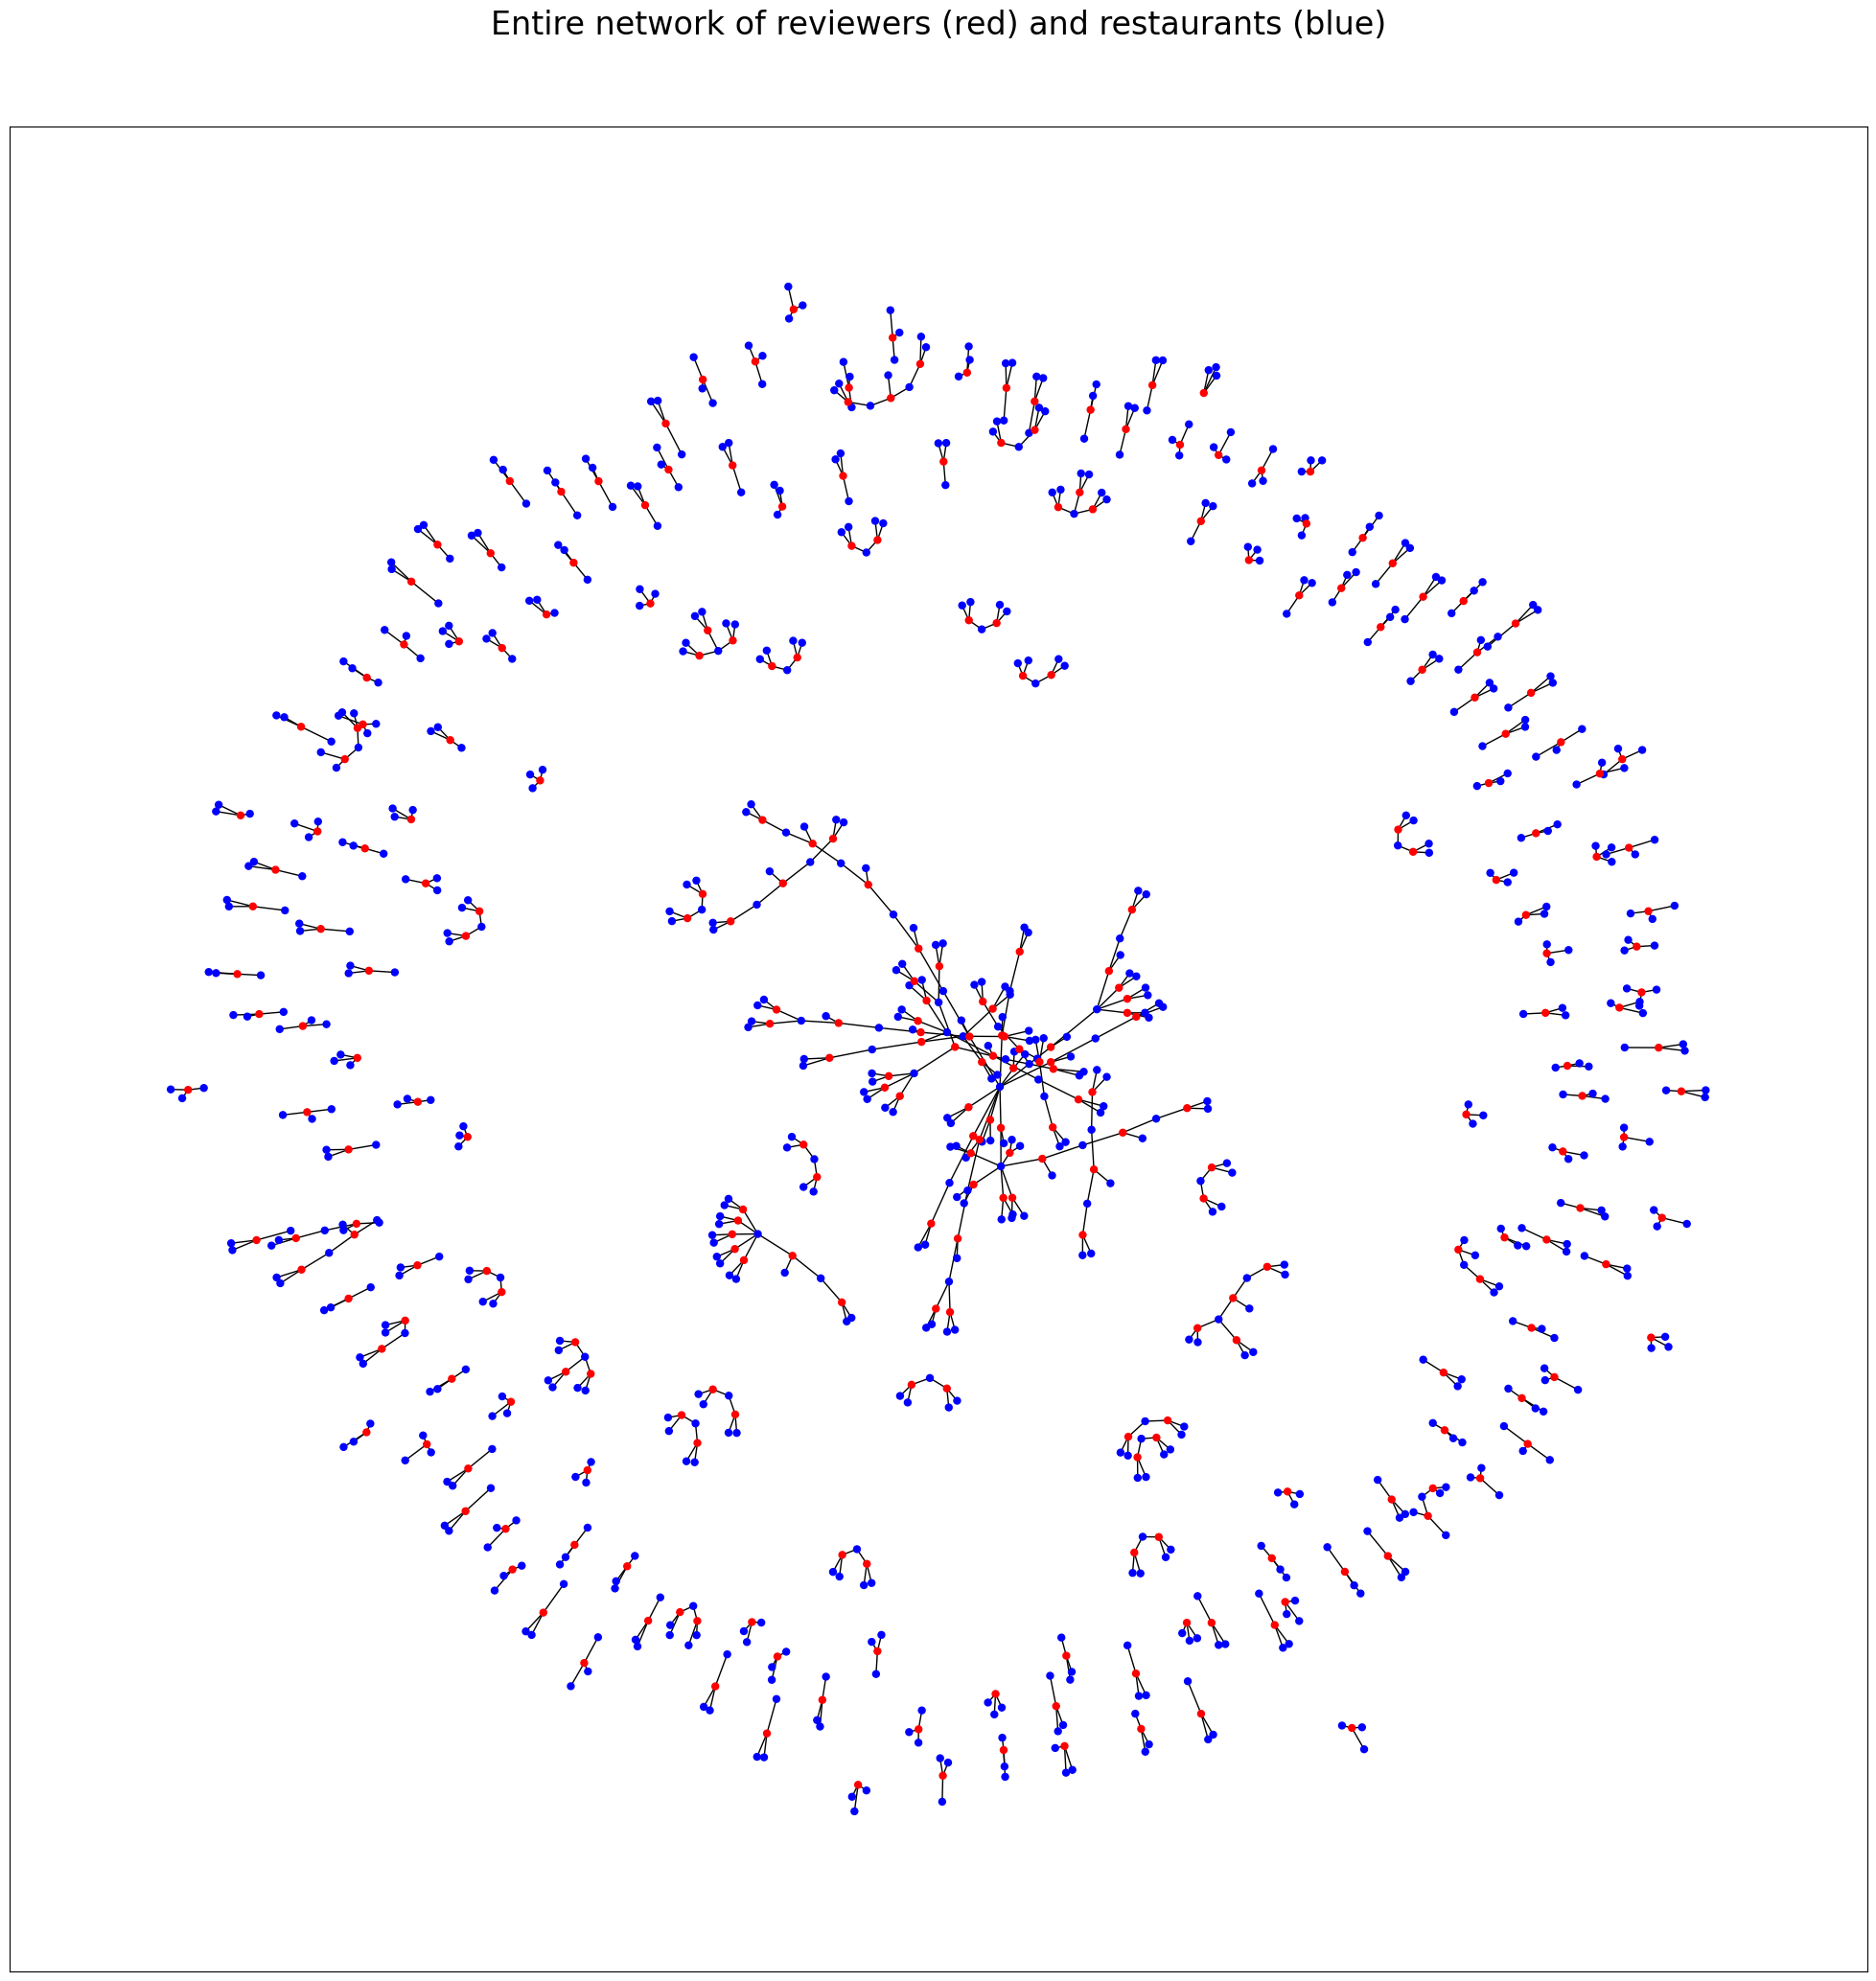

In [216]:
#Create the bipartite graph
graph = nx.Graph()


    
plt.show()
graph.add_nodes_from(restaurant_df['review_user_id']       ,bipartite=1, with_labels=False)
graph.add_nodes_from(restaurant_df['business_id'],bipartite=0, with_labels=False)
#tesing data- for each node there is at least one edge
print(nx.is_connected(graph))

#Returns True if graph G is bipartite, False if not.
print(nx.is_bipartite(graph)) 
node_colors = ['blue' if node_type == 1 else 'red' for node_type in nx.get_node_attributes(graph, 'bipartite').values()]

for i in range(len(restaurant_df)):
  graph.add_edges_from([(restaurant_df.iloc[i,1],restaurant_df.iloc[i,0])])

plt.figure(figsize=(25,25))
plt.text(0.5, 1.05, "Entire network of reviewers (red) and restaurants (blue)", fontsize=24, ha='center', transform=plt.gca().transAxes)
nx.draw_networkx(graph, with_labels=False, node_size=25,node_color=node_colors)
plt.show()


   

In [218]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


#centrality calculations

W  = bipartite.projected_graph(graph, restaurant_df['review_user_id'])
C  = nx.closeness_centrality(W) 
B  = nx.betweenness_centrality(W) 
D  = nx.degree_centrality(W)
E  = nx.eigenvector_centrality(W)
#weighted
#W_weighted = bipartite.weighted_projected_graph(graph, merged_df['Organisation'])
#C_weighted  = nx.closeness_centrality(W2) 
#B_weighted  = nx.betweenness_centrality(W2) 
#D_weighted  = nx.degree(W2)
#E_weighted  = nx.eigenvector_centrality(W2)
#degee_cent=nx.degree_centrality(df)


data = []
for w in restaurant_df['review_user_id']:
    cent_degree = W.degree(w)
    #Organisation_degree_weighted = W_weighted (w, weight='weight')
    Closeness_value = C[w]
    #Closeness_value_weighted=C_weighted[w]
    Betweeness=B[w]
    #Betweeness_weighted=B_weighted[w]
    Degree=D[w]
    #Degree_weighted=D_weighted[w]
    Eigenvector=E[w]
    #Eigenvector_weighted=E_weighted[w]
    
    data.append((w 
                 ,cent_degree#,Organisation_degree_weighted
                 ,Closeness_value#, Closeness_value_weighted      
                 ,Betweeness#, Betweeness_weighted
                 ,Degree#,Degree_weighted
                 ,Eigenvector#,Eigenvector_weighted
                ))

df1 = pd.DataFrame(data, columns=["review_user_id"
                                 ,"Degree"#,"Degree_Weighted"
                                 ,"Closeness"#,"Closeness Centrality Weighted"
                                 ,"Betweeness"#,"Betweenness Centrality Weighted"
                                 ,"Degree_Cent"#,"Degree Centrality Weighted"
                                 ,"Eigenvector"#,"Eigenvector_weighted"
                                ]
                                )

df1 = df1.drop_duplicates()
sorted_df1 = df1.sort_values(by='Degree', ascending=False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sorted_df1

,review_user_id,Degree,Closeness,Betweeness,Degree_Cent,Eigenvector
589,MxtKj5GFmCvijWOLQ1pjdg,19,0.040804,0.006010,0.024772,5.915151e-01
604,rT502dRc8jUxcIdIu0JTLA,14,0.033184,0.003009,0.018253,3.218792e-01
252,uaAJzWR1iipChDerr_hFkg,12,0.015971,0.000272,0.015645,1.778723e-04
591,ux418S1kkyYQzUyvYc8mqQ,10,0.030946,0.001995,0.013038,2.247674e-01
30,uySR3jDEk_DrvUt9fAThYg,10,0.018362,0.000776,0.013038,1.912415e-04
7,X9VCpNQoEz8D20N_OsSg2w,8,0.016321,0.000558,0.010430,1.467220e-04
16,JPH-WOKa6EBMlpBGLIPuiw,8,0.012777,0.000204,0.010430,8.057064e-06
29,QEvgjD61Dy3tynbPN8z88A,6,0.011597,0.000313,0.007823,4.111771e-05
587,mEEnkOj980tl6QuHdKwYNA,6,0.008344,0.000068,0.007823,1.038184e-07
615,APjZtg7VTV3--ygXsAVZxQ,6,0.007823,0.000041,0.007823,3.197156e-08


Below we raise the waterlevel based on degree 

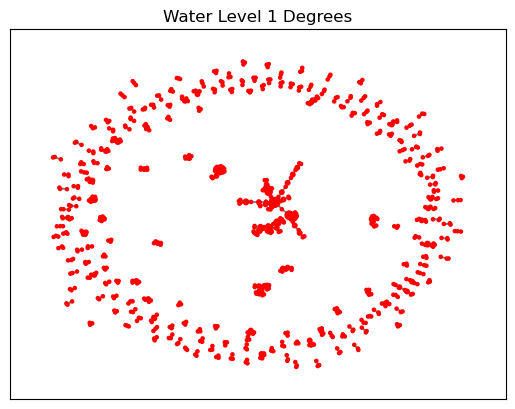

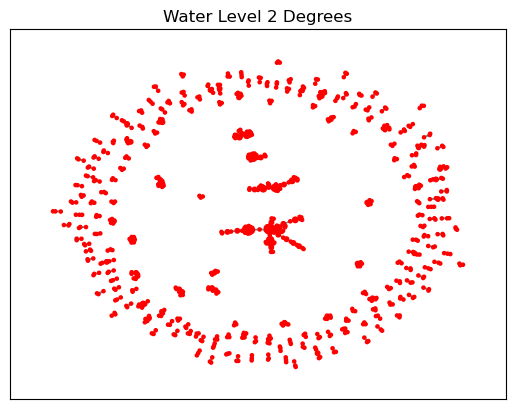

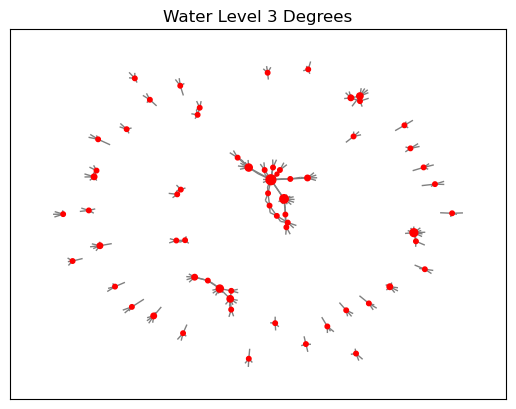

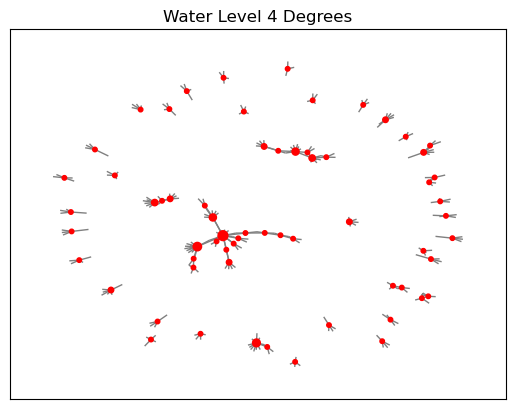

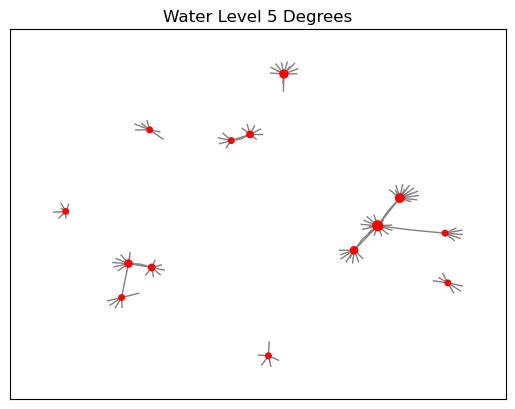

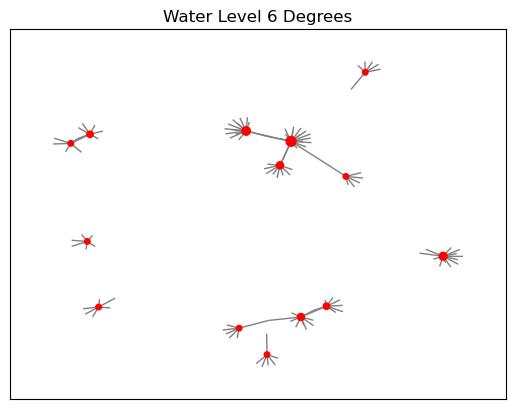

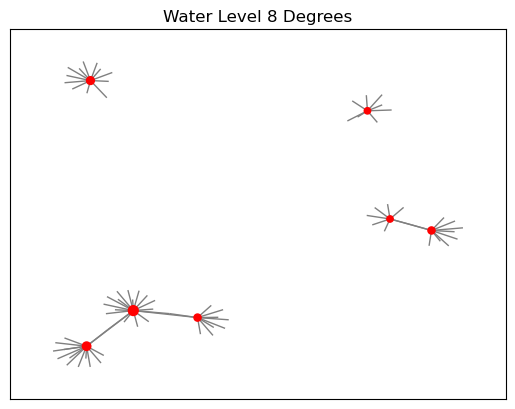

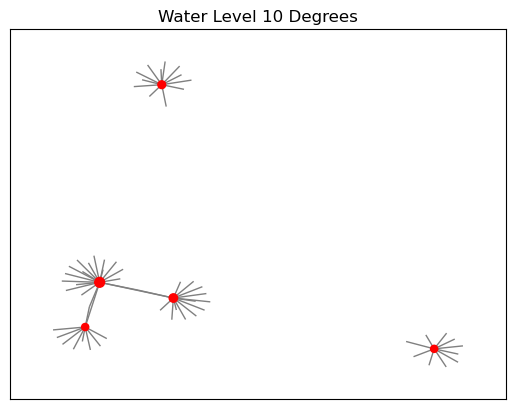

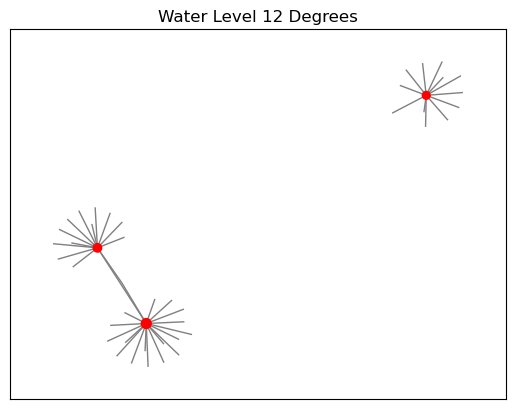

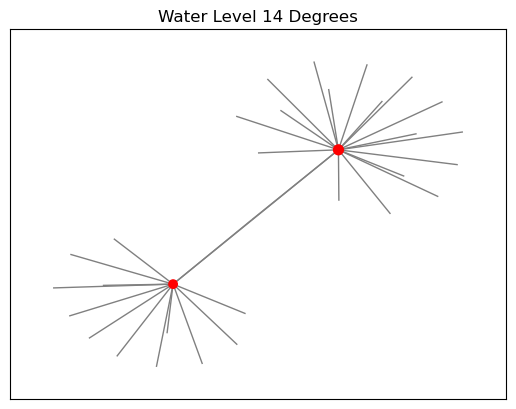

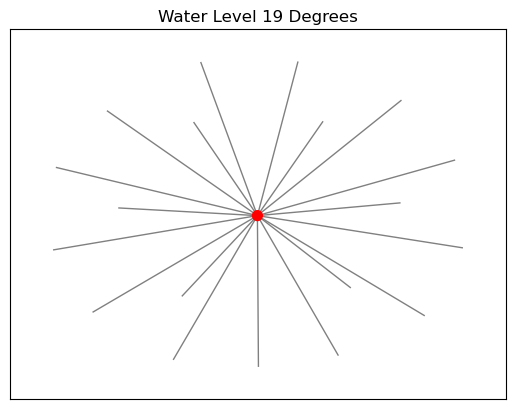

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

def plot_water_level(graph, df, water_level):
    greater_than = df.loc[df['Degree'] >= water_level]
    W = bipartite.projected_graph(graph, greater_than['review_user_id'])
    
    islands = []
    visited = set()
    for node in greater_than['review_user_id']:
        if node not in visited:
            island = nx.node_connected_component(W, node)
            islands.append(island)
            visited.update(island)
    
    level_graph = nx.Graph()
    for island in islands:
        level_graph.add_edges_from(W.subgraph(island).edges())
    
    pos = nx.spring_layout(level_graph)
    
    degree_centrality_values = greater_than.set_index('review_user_id')['Degree']
    max_degree = np.max(degree_centrality_values.values)
    node_sizes = [degree_centrality_values.get(node, 0) / max_degree * 50 for node in level_graph.nodes()]
    
    plt.figure()
    nx.draw_networkx(level_graph,
                     pos,
                     with_labels=False,
                     node_color='red',
                     node_size=node_sizes,
                     edge_color='gray',
                     font_size=8)
    plt.title(f"Water Level {water_level} Degrees")
    plt.show()

# Example usage
plot_water_level(graph, sorted_df1, 1)
plot_water_level(graph, sorted_df1, 2)
plot_water_level(graph, sorted_df1, 3)
plot_water_level(graph, sorted_df1, 4)
plot_water_level(graph, sorted_df1, 5)
plot_water_level(graph, sorted_df1, 6)
plot_water_level(graph, sorted_df1, 8)
plot_water_level(graph, sorted_df1, 10)
plot_water_level(graph, sorted_df1, 12)
plot_water_level(graph, sorted_df1, 14)
plot_water_level(graph, sorted_df1, 19)


######appendix
####################################################
###################################################
#below i try to calculate centrality calculations for the variable 'unique_user_name' but centrality calulcations do not calculate for that variable

False
True


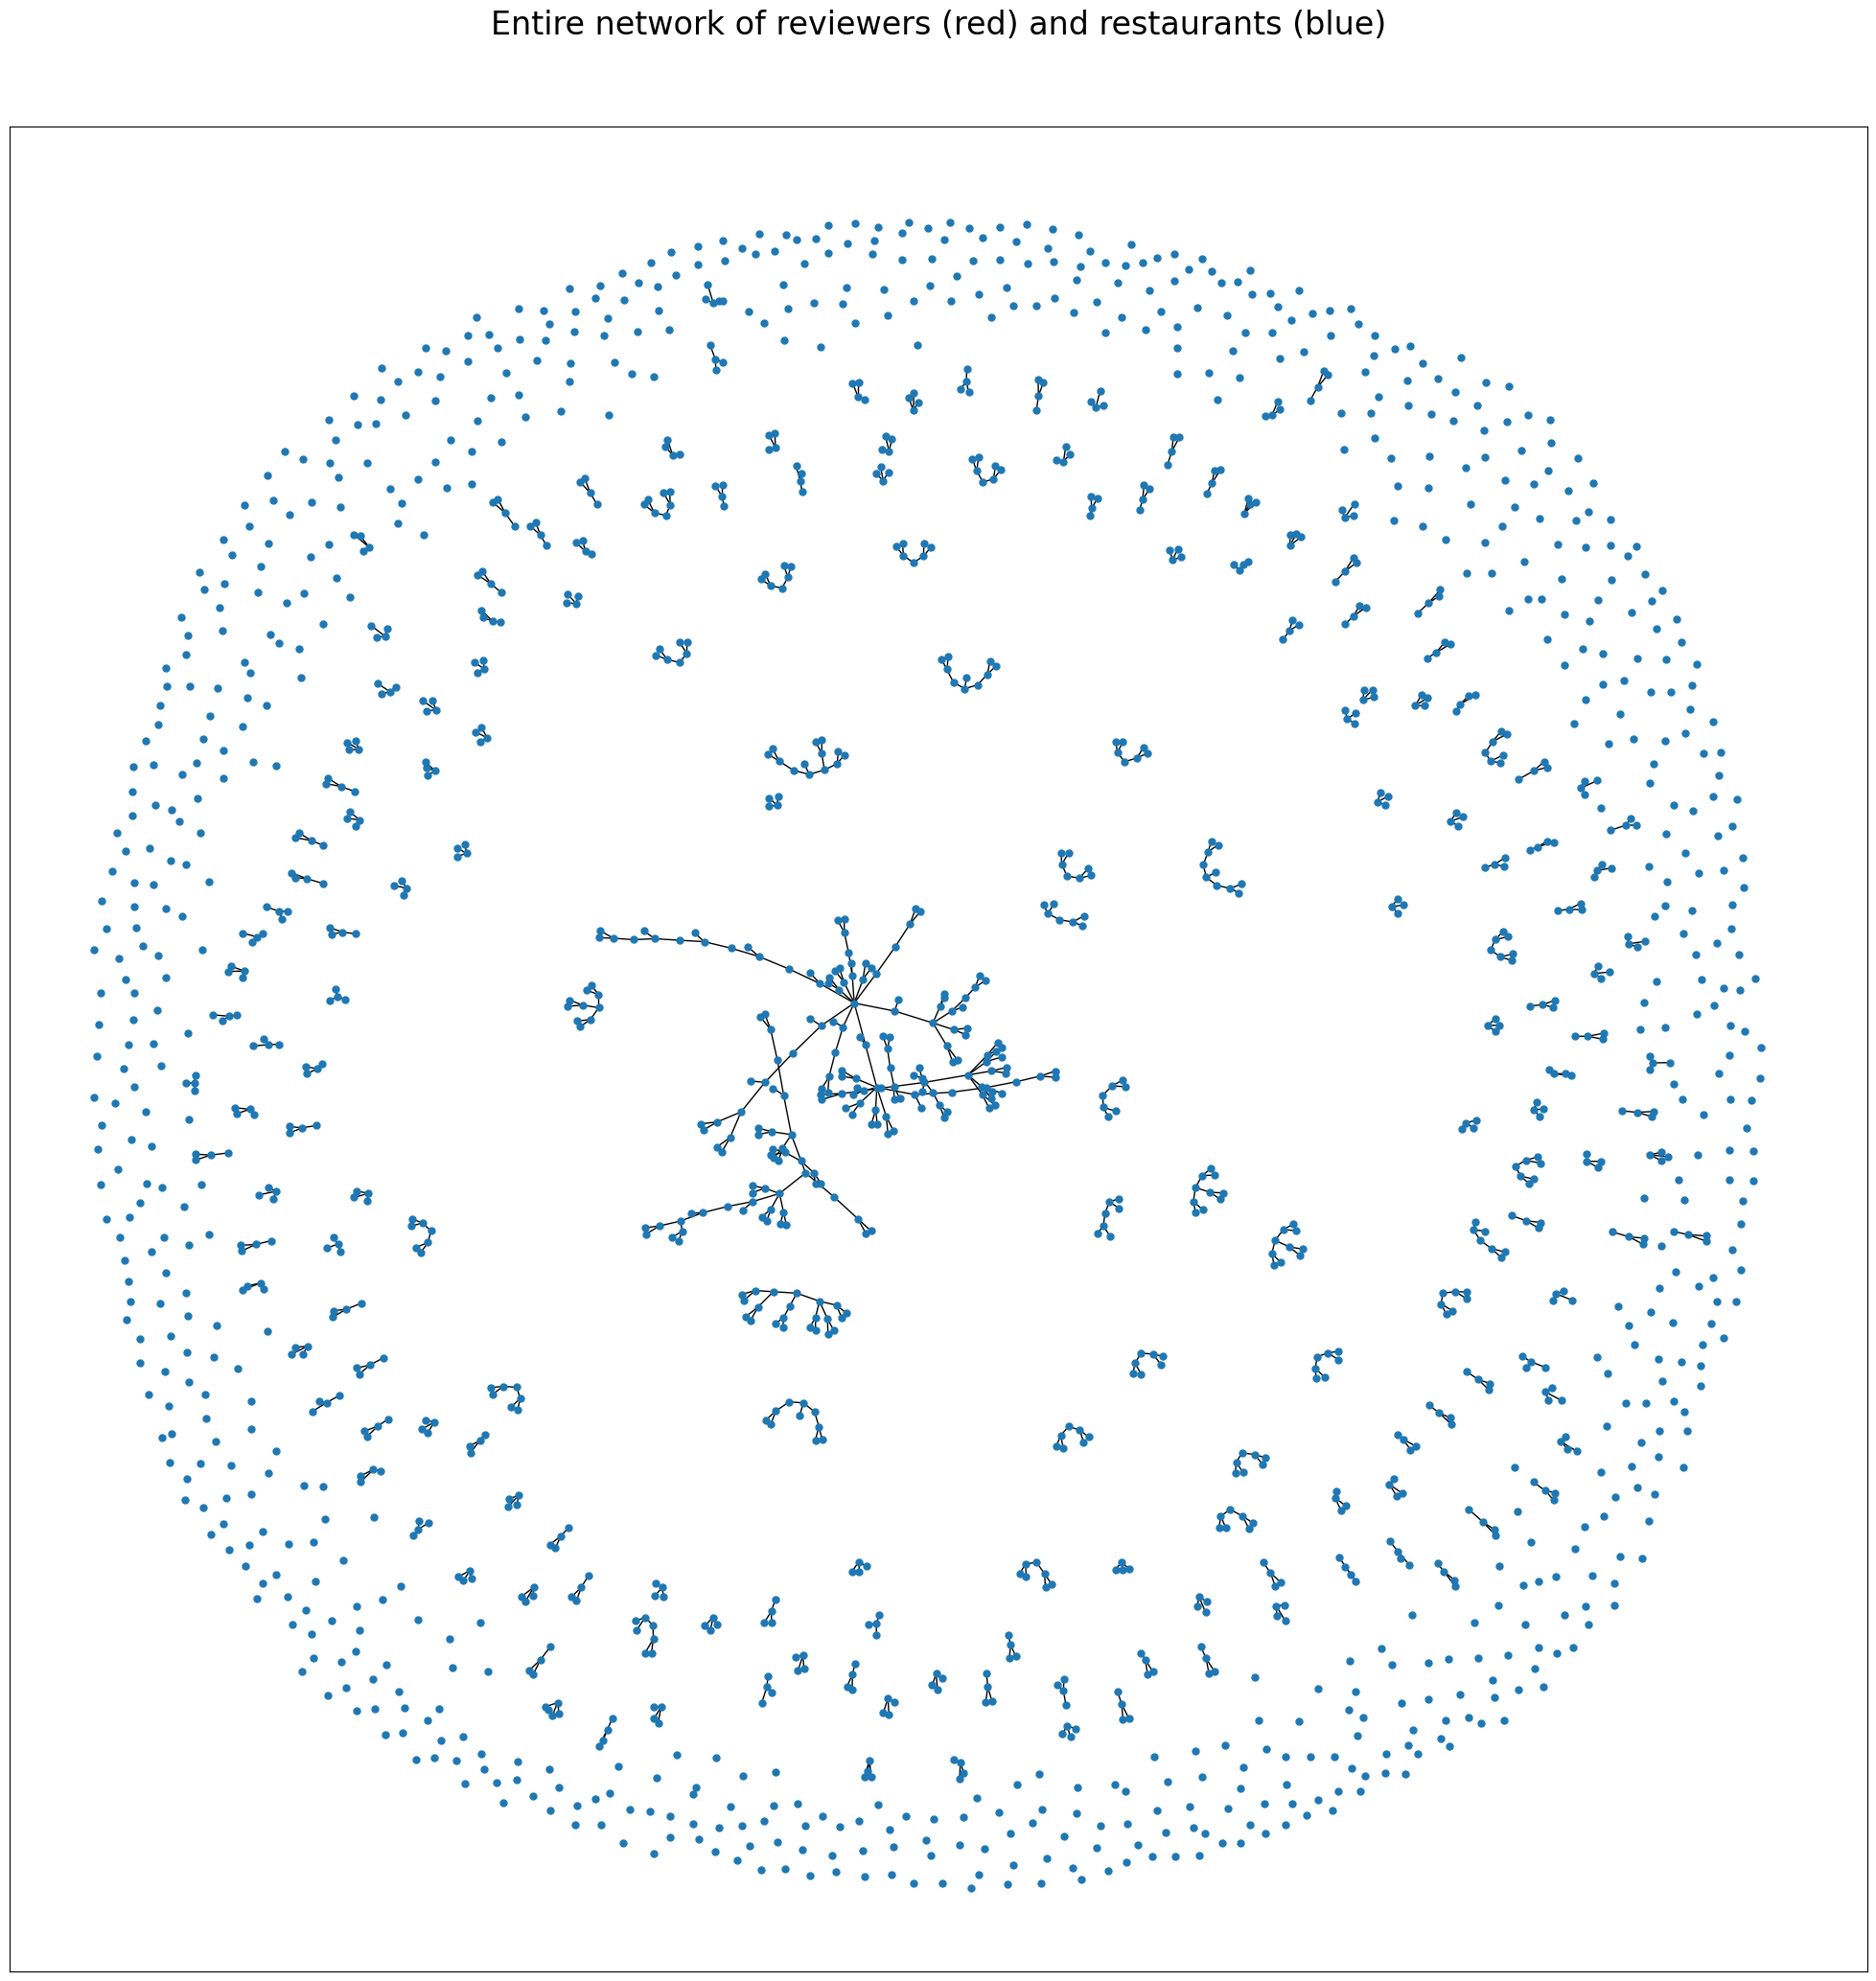

In [226]:
#Create the bipartite graph
graph = nx.Graph()


    
plt.show()
graph.add_nodes_from(restaurant_df['unique_user_name']       ,bipartite=1, with_labels=False)
graph.add_nodes_from(restaurant_df['business_id'],bipartite=0, with_labels=False)
#tesing data- for each node there is at least one edge
print(nx.is_connected(graph))

#Returns True if graph G is bipartite, False if not.
print(nx.is_bipartite(graph)) 
#node_colors = ['blue' if node_type == 1 else 'red' for node_type in nx.get_node_attributes(graph, 'bipartite').values()]

for i in range(len(restaurant_df)):
  graph.add_edges_from([(restaurant_df.iloc[i,1],restaurant_df.iloc[i,0])])

plt.figure(figsize=(25,25))
plt.text(0.5, 1.05, "Entire network of reviewers (red) and restaurants (blue)", fontsize=24, ha='center', transform=plt.gca().transAxes)
nx.draw_networkx(graph, with_labels=False, node_size=25)#,node_color=node_colors)
plt.show()


In [227]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


#centrality calculations

W  = bipartite.projected_graph(graph, restaurant_df['unique_user_name'])
C  = nx.closeness_centrality(W) 
B  = nx.betweenness_centrality(W) 
D  = nx.degree_centrality(W)
E  = nx.eigenvector_centrality(W)
#weighted
#W_weighted = bipartite.weighted_projected_graph(graph, merged_df['Organisation'])
#C_weighted  = nx.closeness_centrality(W2) 
#B_weighted  = nx.betweenness_centrality(W2) 
#D_weighted  = nx.degree(W2)
#E_weighted  = nx.eigenvector_centrality(W2)
#degee_cent=nx.degree_centrality(df)


data = []
for w in restaurant_df['unique_user_name']:
    cent_degree = W.degree(w)
    #Organisation_degree_weighted = W_weighted (w, weight='weight')
    Closeness_value = C[w]
    #Closeness_value_weighted=C_weighted[w]
    Betweeness=B[w]
    #Betweeness_weighted=B_weighted[w]
    Degree=D[w]
    #Degree_weighted=D_weighted[w]
    Eigenvector=E[w]
    #Eigenvector_weighted=E_weighted[w]
    
    data.append((w 
                 ,cent_degree#,Organisation_degree_weighted
                 ,Closeness_value#, Closeness_value_weighted      
                 ,Betweeness#, Betweeness_weighted
                 ,Degree#,Degree_weighted
                 ,Eigenvector#,Eigenvector_weighted
                ))

df1 = pd.DataFrame(data, columns=["unique_user_name"
                                 ,"Degree"#,"Degree_Weighted"
                                 ,"Closeness"#,"Closeness Centrality Weighted"
                                 ,"Betweeness"#,"Betweenness Centrality Weighted"
                                 ,"Degree_Cent"#,"Degree Centrality Weighted"
                                 ,"Eigenvector"#,"Eigenvector_weighted"
                                ]
                                )

df1 = df1.drop_duplicates()
sorted_df1 = df1.sort_values(by='Degree', ascending=False)
##pd.set_option('display.max_rows', None)
##pd.set_option('display.max_columns', None)
sorted_df1

,unique_user_name,Degree,Closeness,Betweeness,Degree_Cent,Eigenvector
0,Thomas_H_MfsHZ,0,0.0,0.0,0.0,0.036084
1,Ashley_K_jv4ic,0,0.0,0.0,0.0,0.036084
557,Nabeel_N_YWsTD,0,0.0,0.0,0.0,0.036084
558,Harris_B_Iu4db,0,0.0,0.0,0.0,0.036084
559,LaToya_K_4Vyg1,0,0.0,0.0,0.0,0.036084
560,C_B_qdj66,0,0.0,0.0,0.0,0.036084
561,Ben_J_D7biV,0,0.0,0.0,0.0,0.036084
562,Daniela_B_4ecxg,0,0.0,0.0,0.0,0.036084
563,Sherry_A_QOpfG,0,0.0,0.0,0.0,0.036084
564,Nick_N_JNuJC,0,0.0,0.0,0.0,0.036084
